### Set seed for reproducibility

In [2]:
import random
import numpy as np
import tensorflow as tf

# Set seeds for random module, NumPy, and TensorFlow
random.seed(699)  # Seed for random module
np.random.seed(699)  # Seed for NumPy
tf.random.set_seed(699)  # Seed for TensorFlow

#### Install required libraries

In [3]:
pip install opencv-python

In [4]:
pip install matplotlib

In [5]:
pip install tensorflow

In [6]:
pip install scikit-learn

In [7]:
pip install pydot

### Mount GDrive

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load and Preprocess Images

We use the other 162 images that we did not use for SAM zero-shot as training for our baseline models.

This is okay because even though the images are not high quality, the model still has advantage since the zero-shot SAM model has NO TRAINING at all

In [9]:
# This code prepares image and mask data for the segmentation task by loading images and masks, resizing them, and
# organizing them into arrays for further processing.

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
from PIL import Image, ImageFilter

# Paths to image and mask folders
images_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/IDCC_Images/Train/cell_images'
masks_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/IDCC_Images/Train/label masks'

# Get list of filenames for images and masks
image_files = [f for f in os.listdir(images_folder) if f.endswith('.tiff')]
mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.png')]

# Match image and mask filenames based on shared base names
paired_files = [(os.path.splitext(f)[0], os.path.splitext(f)[0]) for f in image_files if os.path.splitext(f)[0] + '.png' in mask_files]

image_data = []
mask_data = []

# Loop through paired files
for paired_file in paired_files:
    img_filename, mask_filename = paired_file

    img_path = os.path.join(images_folder, img_filename + '.tiff')
    mask_path = os.path.join(masks_folder, mask_filename + '.png')

    # Load image and mask using OpenCV, resize them, and append to respective lists
    image = cv2.imread(img_path, 0)  # Read image in grayscale
    image = cv2.resize(image, dsize=(768, 512), interpolation=cv2.INTER_AREA)  # Resize image. We use 768 x 512 to make dimension computations easier in the UNET layers
    image_data.append(np.array(image))  # Append resized image to image_data list

    mask = cv2.imread(mask_path, 0)  # Read mask in grayscale
    mask = cv2.resize(mask, dsize=(768, 512), interpolation=cv2.INTER_AREA)  # Resize mask
    mask_data.append(np.array(mask))  # Append resized mask to mask_data list

# Convert image_data and mask_data lists to numpy arrays, normalize values to range [0, 1]
image_data = np.expand_dims(np.array(image_data), 3) / 255  # Convert to numpy array and normalize pixel values
mask_data = np.expand_dims(np.array(mask_data), 3) / 255  # Convert to numpy array and normalize pixel values


Sanity Check -- Let's look at first image and its mask image:

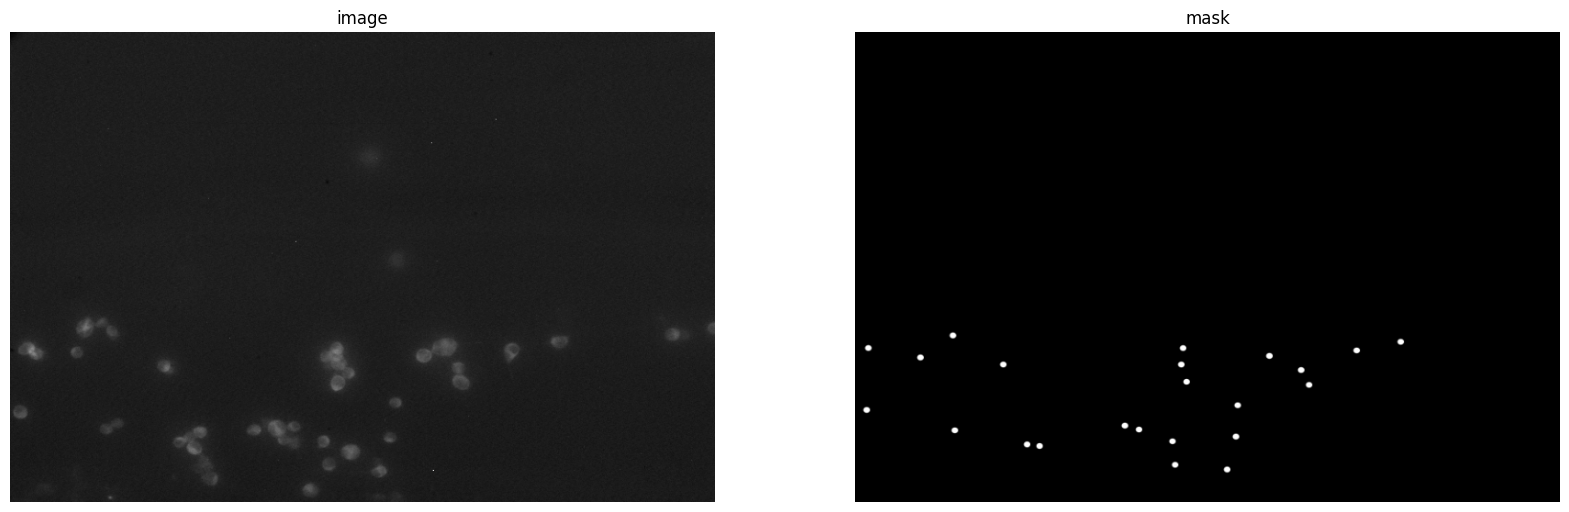

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(image_data[0], cmap='gray')
ax[0].set_title('image')
ax[0].axis('off')
ax[1].imshow(mask_data[0], cmap='gray')
ax[1].set_title('mask')
ax[1].axis('off')
fig.show()

## Let's define our U-Net Architecture

In [17]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout


# The model has two main parts:

# 1. Contracting Path: This part helps to understand the broader picture, like capturing the basic shapes and features.
# It consists of convolutional layers that learn to recognize simple patterns and pooling layers that summarize this information.

# 2. Expanding Path: It takes the understanding gained in the contracting path and refines it, adding more detail and precision.
# It involves upsampling layers that help reconstruct the detailed information lost during pooling and combines it with the broader context.

# Define U-Net model

# Define input shape based on image_data's dimensions
s = Input((image_data.shape[1], image_data.shape[2], image_data.shape[3]))

# Contraction path
# First set of convolutional layers and pooling
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Second set of convolutional layers and pooling
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

# Third set of convolutional layers
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

# Expansive path
# First upsampling and concatenation with skip connection
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

# Second upsampling and concatenation with skip connection
u5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

# Create the model
model = Model(inputs=[s], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Display model summary
#model.summary()


### Split data to train and validation

##### We will use the same 100 images we ran on SAM Zero-shot segmentation as our test images later

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_data, mask_data, test_size=0.20, random_state=2024)

print('train data size:', X_train.shape[0], '\n')
print('validation data size:', X_val.shape[0], '\n')

train data size: 129 

validation data size: 33 



### Train model

In [19]:
import time

# Record the start time
start_time = time.time()

history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 32,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    epochs = 50)

# Record the end time
end_time = time.time()

# Calculate the duration
training_duration = end_time - start_time
print(f"Training took {training_duration} seconds.")

Epoch 1/50
5/5 [==============================] - 7s 683ms/step - loss: 0.6423 - accuracy: 0.9784 - val_loss: 0.5929 - val_accuracy: 0.9770
Epoch 2/50
5/5 [==============================] - 3s 583ms/step - loss: 0.5441 - accuracy: 0.9663 - val_loss: 0.4374 - val_accuracy: 0.9446
Epoch 3/50
5/5 [==============================] - 3s 586ms/step - loss: 0.3661 - accuracy: 0.9675 - val_loss: 0.2418 - val_accuracy: 0.9828
Epoch 4/50
5/5 [==============================] - 3s 603ms/step - loss: 0.1441 - accuracy: 0.9885 - val_loss: 0.1699 - val_accuracy: 0.9831
Epoch 5/50
5/5 [==============================] - 3s 563ms/step - loss: 0.1141 - accuracy: 0.9888 - val_loss: 0.1537 - val_accuracy: 0.9831
Epoch 6/50
5/5 [==============================] - 3s 566ms/step - loss: 0.0827 - accuracy: 0.9888 - val_loss: 0.1082 - val_accuracy: 0.9831
Epoch 7/50
5/5 [==============================] - 3s 590ms/step - loss: 0.0755 - accuracy: 0.9888 - val_loss: 0.1050 - val_accuracy: 0.9831
Epoch 8/50
5/5 [====

In [20]:
#Save the model

model.save('/content/drive/MyDrive/Final IDCC-SAM/UNet/saved models/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting results of the model icluding accuracy, validation accuracy, loss and validation loss

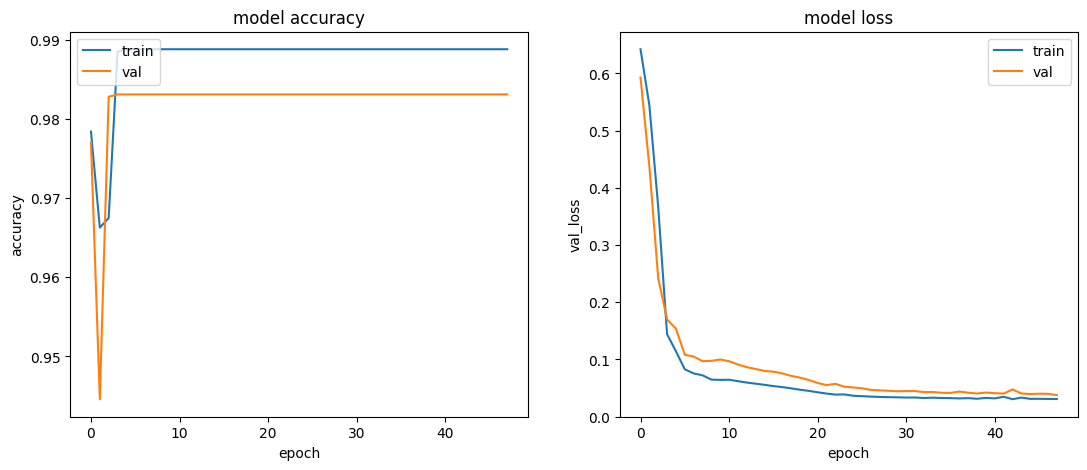

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

### Evaluate Model

Load in saved model

In [22]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/Final IDCC-SAM/UNet/saved models/model1.h5')

Load in test images, their corresponding masks, and ground truth CSV files

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Paths to image, mask, and ground truth folders
images_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/IDCC_Images/Test'
masks_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/IDCC_Images/Test_label masks'
ground_truth_folder = '/content/drive/MyDrive/Final IDCC-SAM/UNet/all-groundtruth'

# Get a list of filenames for images
image_files = [f for f in os.listdir(images_folder) if f.endswith('.tiff')]

# Initialize lists to store image, mask, and ground truth data
image_data = []
mask_data = []
ground_truth_data = []

# Initialize lists to store image names
image_names = []

for img_filename in image_files:
    # File paths for image, mask, and ground truth
    img_path = os.path.join(images_folder, img_filename)
    mask_path = os.path.join(masks_folder, img_filename.replace('.tiff', '.png'))
    gt_path = os.path.join(ground_truth_folder, img_filename.replace('.tiff', '.csv'))

    # Load image using OpenCV
    image = cv2.imread(img_path, 0)
    image = cv2.resize(image, dsize=(768, 512), interpolation=cv2.INTER_AREA)
    image_data.append(np.array(image))

    # Load mask using OpenCV
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, dsize=(768, 512), interpolation=cv2.INTER_AREA)
    mask_data.append(np.array(mask))

    img_name = img_filename.split('.')[0]  # Extract image name without extension
    image_names.append(img_name)  # Append image name to list

    # Load ground truth from CSV
    if os.path.exists(gt_path):
        ground_truth = pd.read_csv(gt_path)
        ground_truth_data.append(ground_truth)

# Convert lists to numpy arrays
image_data = np.expand_dims(np.array(image_data), 3) / 255
mask_data = np.expand_dims(np.array(mask_data), 3) / 255


Run Evaluation

In [ ]:
from scipy import ndimage
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image

def previewResults():
    testCases = image_data  # Use the loaded images
    testGroundTruth = mask_data  # Use the loaded masks
    imageNames = image_names

    # Run predictions
    predictions = loaded_model.predict(testCases)

    results_table = []
    within_5 = 0  # Counter for images within +/-5% AAE
    within_10 = 0  # Counter for images within +/-10% AAE
    greater_than_10 = 0  # Counter for images greater than +/-10% AAE

    for idx, (img, pred_mask, actual, gt, names) in enumerate(zip(testCases, predictions, testGroundTruth, ground_truth_data, imageNames)):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))

        ax[0].imshow(img.squeeze(), cmap='gray')
        ax[0].set_title(f"Image Name:\n {names}")
        ax[0].axis('off')

        ax[1].imshow(actual.squeeze(), cmap='gray')
        ax[1].set_title(f"Ground Truth\nCells Count: {len(gt)}")
        ax[1].axis('off')

        img_mask = np.squeeze(pred_mask)
        plt.imsave('test.png', img_mask)

        image = Image.open('test.png').convert("L")
        img = np.asarray(image)
        img = img.copy()
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        t = 40
        (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

        # Convert grayscale image to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Find contours depending on OpenCV version
        if cv2.__version__.startswith('3.'):
            (_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        elif cv2.__version__.startswith('4.'):
            (contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            raise ValueError("Unsupported OpenCV version")

        # Draw each contour with a different color
        for i, c in enumerate(contours):
            # Generate a random color for each contour
            color = np.random.randint(0, 256, 3)  # Random RGB color
            # Draw contour filled with the generated color
            cv2.drawContours(img_color, [c], -1, color.tolist(), thickness=cv2.FILLED)

        ax[2].imshow(img_color, cmap='gray')  # Show labeled components
        ax[2].set_title(f"Predicted\nCells Count: {len(contours)}")
        ax[2].axis('off')

        # Calculate AAE difference

            # Calculate AAE difference
        #if len(gt) != 0:
        num_cells_pred = len(contours)
        difference = abs(num_cells_pred - len(gt))

        results_table.append({'Image Name': names, 'Ground Truth': len(gt), 'Prediction': num_cells_pred, 'Percentage Difference': difference})

        # Check if within +/-5 difference
        if abs(difference) <= 5:
            within_5 += 1

        # Check if within +/-10 difference
        if (abs(difference) > 5 and abs(difference) <= 10):
            within_10 += 1

        # Check if within +/-20 difference
        if abs(difference) > 10:
            greater_than_10 += 1

        plt.tight_layout()
        plt.show()

    # Display the results table
    results_df = pd.DataFrame(results_table)
    print(results_df)

    # Calculate the ACPs
    total_images = len(testCases)
    percent_within_5 = (within_5 / total_images) * 100
    percent_within_10 = (within_10 / total_images) * 100
    percent_greater_than_10 = (greater_than_10 / total_images) * 100

    print(f"AAE within +/-5: {percent_within_5}%")
    print(f"AAE within +/-10: {percent_within_10}%")
    print(f"AAE greater than +/-10: {percent_greater_than_10}%")

previewResults()

In [34]:
import os
import pandas as pd
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from PIL import Image

def previewResults():
    testCases = image_data  # Use the loaded images
    testGroundTruth = mask_data  # Use the loaded masks
    imageNames = image_names

    # Run predictions
    predictions = loaded_model.predict(testCases)

    results_table = []
    within_5 = 0  # Counter for images within +/-5 AAE
    within_10 = 0  # Counter for images within +/-10 AAE
    greater_than_10 = 0  # Counter for images greater than +/-10 AAE

    # Create a directory to save the plots as images
    output_folder_plots = '/content/drive/MyDrive/Final IDCC-SAM/UNet/Test Results/test_segmentation output'
    os.makedirs(output_folder_plots, exist_ok=True)

    for idx, (img, pred_mask, actual, gt, names) in enumerate(zip(testCases, predictions, testGroundTruth, ground_truth_data, imageNames)):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))

        ax[0].imshow(img.squeeze(), cmap='gray')
        ax[0].set_title('Input')
        ax[0].axis('off')

        ax[1].imshow(actual.squeeze(), cmap='gray')
        ax[1].set_title(f"Ground Truth\nCells Count: {len(gt)}")
        ax[1].axis('off')

        img_mask = np.squeeze(pred_mask)
        plt.imsave('test.png', img_mask)

        image = Image.open('test.png').convert("L")
        img = np.asarray(image)
        img = img.copy()
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        t = 50
        (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

        # Convert grayscale image to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Find contours depending on OpenCV version
        if cv2.__version__.startswith('3.'):
            (_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        elif cv2.__version__.startswith('4.'):
            (contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            raise ValueError("Unsupported OpenCV version")

        # Draw each contour with a different color
        for i, c in enumerate(contours):
            # Generate a random color for each contour
            color = np.random.randint(0, 256, 3)  # Random RGB color
            # Draw contour filled with the generated color
            cv2.drawContours(img_color, [c], -1, color.tolist(), thickness=cv2.FILLED)

        ax[2].imshow(img_color, cmap='gray')  # Show labeled components
        ax[2].set_title(f"Predicted\nCells Count: {len(contours)}")
        ax[2].axis('off')

        num_cells_pred = len(contours)

        # Calculate AAE difference
        difference = abs(num_cells_pred - len(gt))
        results_table.append({'Image Name': names, 'Ground Truth': len(gt), 'Prediction': num_cells_pred, 'Absolute Difference': difference})

        # Check if within +/-5 difference
        if abs(difference) <= 5:
            within_5 += 1

        # Check if within +/-10 difference
        if (abs(difference) > 5 and abs(difference) <= 10):
            within_10 += 1

        # Check if within +/-20 difference
        if abs(difference) > 10:
            greater_than_10 += 1

        plt.tight_layout()

        # Save the plot as an image
        output_filename_plot = os.path.join(output_folder_plots, f'{names}.png')
        plt.savefig(output_filename_plot, bbox_inches='tight')
        plt.close()

    # Display the results table
    results_df = pd.DataFrame(results_table)
    results_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/UNet/Test Results/UNet final prediction summary_table.xlsx'
    results_df.to_excel(results_excel_path, index=False)

    # Calculate the AAEs
    total_images = len(testCases)
    percent_within_5 = (within_5 / total_images) * 100
    percent_within_10 = (within_10 / total_images) * 100
    percent_greater_than_10 = (greater_than_10 / total_images) * 100

    print(f"AAE within +/-5: {percent_within_5}%")
    print(f"AAE within +/-10: {percent_within_10}%")
    print(f"AAE greater than +/-10: {percent_greater_than_10}%")

previewResults()

4/4 [==============================] - 1s 160ms/step
AAE within +/-5: 21.0%
AAE within +/-10: 11.0%
AAE greater than +/-10: 68.0%


In [35]:
import pandas as pd

# Read the Excel file
excel_file = '/content/drive/MyDrive/Final IDCC-SAM/UNet/Test Results/UNet final prediction summary_table.xlsx'
df = pd.read_excel(excel_file)

# Add a new column "Image Type" with initial value as empty string
df['Image Type'] = ''

# Function to label Image Type based on Image Name
def label_image_type(image_name):
    # Convert image name to lowercase for case-insensitive comparison
    image_name_lower = image_name.lower()

    # Check if image name contains both "DAPI" and any of the other specified substrings
    if 'dapi' in image_name_lower:
        for substring in ['ki67', 'gfab', 'map2ab', 'nestin', 'rip', 'tuj1']:
            if substring in image_name_lower:
                return 'DAPI'
    # Check if image name contains any of the specified substrings
    if 'gfap' in image_name_lower and 'dapi' not in image_name_lower:
        return 'GFAP'
    elif 'ki67' in image_name_lower and 'dapi' not in image_name_lower:
        return 'KI67'
    elif 'map2ab' in image_name_lower and 'dapi' not in image_name_lower:
        return 'MAP2ab'
    elif 'nestin' in image_name_lower and 'dapi' not in image_name_lower:
        return 'Nestin'
    elif 'rip' in image_name_lower and 'dapi' not in image_name_lower:
        return 'RIP'
    elif 'tuj1' in image_name_lower and 'dapi' not in image_name_lower:
        return 'TuJ1'
    else:
        return 'DAPI'

# Apply the function to label Image Type based on Image Name
df['Image Type'] = df['Image Name'].apply(label_image_type)

# Save the updated DataFrame to the Excel file
df.to_excel(excel_file, index=False)

print("Image Type column added and labeling completed.")


Image Type column added and labeling completed.


In [36]:
import pandas as pd

# Read the Excel file
excel_file = '/content/drive/MyDrive/Final IDCC-SAM/UNet/Test Results/UNet final prediction summary_table.xlsx'
df = pd.read_excel(excel_file)

# Function to calculate the analysis
def calculate_analysis(group):
    # Filter rows where "Absolute Difference" column is <= 10
    filtered_rows = group[group['Absolute Difference'] <= 10]
    # Calculate the count of such rows
    count = len(filtered_rows)
    # Calculate the total count of rows for the image type
    total_count = len(group)
    # Calculate the ratio of filtered rows to total rows
    ratio = count / total_count if total_count > 0 else 0
    return ratio

# Group by "Image Type" and apply the analysis function
analysis_result = df.groupby('Image Type').apply(calculate_analysis)

# Add the analysis result to the DataFrame
df['Analysis Result'] = df['Image Type'].map(analysis_result)

# Save the DataFrame back to the Excel file
df.to_excel(excel_file, index=False)

print("Analysis result saved to Excel file.")


Analysis result saved to Excel file.
